In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Todd Ideas,249.537287,62.384322,85.709222,4
Azure Private DNS,260.923239,13.732802,19.788934,19
RAG Project,665.097281,41.568580,53.570523,16
Azure AD Authentication,864.262626,66.481740,125.598178,13
Azure Functions + Visual Studio,1085.725908,83.517378,288.072004,13
Email Auth and Security,1089.718862,90.809905,205.993444,12
Azure DevOps Pipelines,1221.734614,46.989793,107.733773,26
Open Source/GitHub,1228.213028,76.763314,185.466910,16
Audit Report Tracker (Sharepoint List),1322.484149,110.207012,375.742208,12
WSL + Kali Linux,1548.402995,110.600214,330.945409,14


# Histogram

sum of ages: ~47168.76


<Axes: >

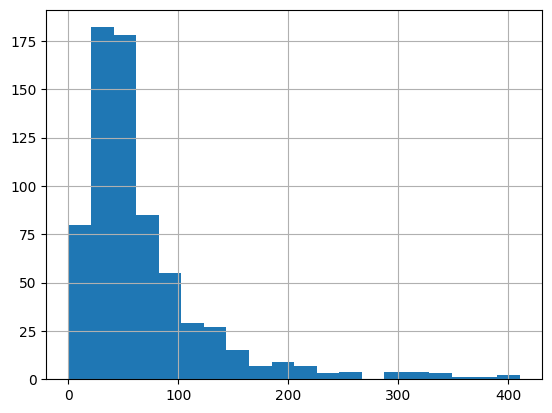

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 696
Total card age: 47168.76


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
111,Todd Ideas,"In Azure AI Document Intelligence, The results...",81c5a16ccf56aee2942d3a919a07b581,85.709222,62.384322,85.709222,249.537287,0.525460,4,0,0,-85.709222
347,Todd Ideas,"In Azure AI Document Intelligence, document an...",935798db6bcd524d7034621caf8b31cc,75.548098,62.384322,85.709222,249.537287,0.525460,4,1,0,-75.548098
572,Todd Ideas,"In Azure AI Document Intelligence, the service...",e9f2f2eaf4cf59655b56fc627c2d57ca,52.311525,62.384322,85.709222,249.537287,0.525460,4,2,0,-52.311525
112,Todd Ideas,"In Azure AI Document Intelligence, although pr...",cad3d64870a499cc1c11ef9cee9ae764,35.968442,62.384322,85.709222,249.537287,0.525460,4,3,0,-35.968442
15,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,375.742208,110.207012,375.742208,1322.484149,0.930719,12,0,0,-375.742208
33,Email Auth and Security,Email Authentication Alignment\n\nEnsuring tha...,14bc6ca0af379197455f1cd5febad55c,205.993444,90.809905,205.993444,1089.718862,0.554468,12,0,0,-205.993444
256,Audit Report Tracker (Sharepoint List),List Items Endpoint (for retrieving items in a...,ab53dedb8adaa3ad12a6afcdb2e1dd65,165.526606,110.207012,375.742208,1322.484149,0.930719,12,1,0,-165.526606
273,Email Auth and Security,SMTP (Simple Mail Transfer Protocol)\n\nThe st...,6d00c60b39db9ac1eabdc490adf128a4,150.575416,90.809905,205.993444,1089.718862,0.554468,12,1,0,-150.575416
484,Audit Report Tracker (Sharepoint List),Column (SharePoint Column)\nDefinition: A fiel...,3320c1d28b4a2badbaf91d674cdaec02,138.932042,110.207012,375.742208,1322.484149,0.930719,12,2,0,-138.932042
501,Email Auth and Security,p=none\n\nA DMARC policy action.\nRequests no ...,98ed919f7e08cbf83347817d193116c3,124.430009,90.809905,205.993444,1089.718862,0.554468,12,2,0,-124.430009



## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
691,Vocab,Pharmacogenetic Markers\nPronunciation: FAR-ma...,3009bd7fe72e3d6ee9806545710698a3,0.316995,52.693925,308.497022,4689.759298,0.795994,89,88,8,-0.316995
685,Vocab,Trimalleolar Fracture\nPronunciation: try-mal-...,4dcad89aa29d13661e3c94b11bc85736,0.486146,52.693925,308.497022,4689.759298,0.795994,89,87,8,-0.486146
686,Vocab,Codicil\nPronunciation: KOH-duh-sil\nDefinitio...,0310eee28c7c8e1d32a74a10ac19035c,0.590580,52.693925,308.497022,4689.759298,0.795994,89,86,8,-0.590580
692,Vocab,Debride a Wound\nPronunciation: dih-BREED uh w...,80480f0451393019c45f9347790b2cd1,0.647259,52.693925,308.497022,4689.759298,0.795994,89,85,8,-0.647259
687,Vocab,Crewelwork\nPronunciation: KROO-uhl-wurk\nDefi...,c8bbca3ba3939d12457339fca1e6d4af,0.719903,52.693925,308.497022,4689.759298,0.795994,89,84,8,-0.719903
694,Vocab,Truckle\nPronunciation: TRUHK-uhl\nDefinition:...,5fdce68ef8fe3099d885821dfb12467d,0.969116,52.693925,308.497022,4689.759298,0.795994,89,83,8,-0.969116
690,Vocab,Probate\nPronunciation: PROH-bayt\nDefinition:...,b455a7208bbdaea9b06018deb9fc0900,1.243670,52.693925,308.497022,4689.759298,0.795994,89,82,8,-1.243670
693,Vocab,Gethsemane\nPronunciation: geth-SEM-uh-nee\nDe...,52962e7f988069e7bf0806f5303e2550,2.117130,52.693925,308.497022,4689.759298,0.795994,89,81,8,-2.117130
688,Vocab,Tulle\nPronunciation: tool\nDefinition: A ligh...,9bdb0cc9a85e9897234cfe12b30f3801,2.469670,52.693925,308.497022,4689.759298,0.795994,89,80,8,-2.469670
689,Vocab,Stollen (bread)\nPronunciation: SHTOH-luhn\nDe...,170046f637ed1f719010eea4a3703375,2.961521,52.693925,308.497022,4689.759298,0.795994,89,79,7,-2.961521


In [18]:
existing_cards.head(10).sum()

head                   Todd IdeasTodd IdeasTodd IdeasTodd IdeasAudit ...
body                   In Azure AI Document Intelligence, The results...
hash                   81c5a16ccf56aee2942d3a919a07b581935798db6bcd52...
age                                                          1410.737013
subject_mean_age                                               852.58804
subject_highest_age                                          2088.043844
subject_age_sum                                              8234.758183
head_random_roll                                                6.557402
frequency                                                             88
count                                                                 12
n_fold                                                                 0
neg_age                                                     -1410.737013
dtype: object

In [19]:
existing_cards['age'].mean()

np.float64(67.7712138482456)